# cell2vec

In this notebook, we will be exploring the ideas of using a shallow neural net to hopefully construct on order of hundred(s)-length distributed representation of cells.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib notebook
%matplotlib inline

/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:278: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  'Matplotlib is building the font cache using fc-list. '


In [2]:
import boto3
import botocore
import loompy
import matplotlib.pyplot as plt
import numpy as np
import torch

from collections import Counter

First let's download the data and take a look at what's in it! All of our data will be store in ```/data```.

In [3]:
data_dir = 'data/'

BUCKET_NAME = 'hca-beta-demo-matrices'
KEY = 'full_hca_subsample.loom'

s3 = boto3.resource('s3')

try:
    s3.Bucket(BUCKET_NAME).download_file(KEY, data_dir + KEY)
except botocore.exceptions.ClientError as e:
    if e.response['Error']['Code'] == "404":
        print("The object does not exist.")
    else:
        raise

In [24]:
ds = loompy.connect("data/full_hca_subsample.loom")
gene_by_cells_total = ds[:, :]

# Print out dimensions of the matrix
print(f"The dimensions (number of genes by the number of cells) of the matrix are: {ds.shape}\n")

# Print an interesting subset of the matrix
print(f"A non-zero bit of the matrix: \n{ds[42894:42910, 42894:42910]}\n")

# Print other interesting bits of information
number_of_nonzero_vals = np.count_nonzero(gene_by_cells_total) # Takes a couple minutes to run
print(f"Number of non-zero entries: {number_of_nonzero_vals}. Percentage = {(100 * number_of_nonzero_vals) / (ds.shape[0] * ds.shape[1])}")

# Print attributes of the cells & genes that have been sequenced
print(f"Cell attributes: {ds.ca.keys()}\n")
print(f"Gene attributes: {ds.ra.keys()}")

# Some interesting attributes...
organ_labels = ds.ca["organ_label"]
unique_organ_labels = np.unique(organ_labels)
print(f"\nThe organ (via labels) that appear to exist in this data are: \n{unique_organ_labels}")
cells_by_organ_type = Counter(organ_labels)
print(cells_by_organ_type)

batches = ds.ca["short_name"]
unique_batches = np.unique(batches)
print(f"\nThe dataset comes from roughly {len(unique_batches)} datasets. Labels are:\n{unique_batches}")
cells_by_batches = Counter(batches)
print(cells_by_batches)

The dimensions (number of genes by the number of cells) of the matrix are: (63880, 48828)

A non-zero bit of the matrix: 
[[76.  1.  2.  1.  1.  1.  2.  5.  1.  0.  3.  0.  2.  0.  5.  2.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  1.  0.  2.  0.  0.  3.  0.  1.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  1.  0.  0.  2.  0.  0.  0.  0.  0.  0.  0.  1.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [17.  

## Address Sparsity Round 1
One problem with the current matrix is that most of the values in the matrix are zeroes. From above, you can see that only 1.55 percent are non-zero. Let's try to remove information about genes that aren't expressed at all in any of the cells and see where that makes us land

In [5]:
gene_by_cell_minus_expressionless_genes = gene_by_cells_total[~np.all(gene_by_cells_total==0.0, axis=1)]

In [6]:
print(f"After removing genes with zero expression in any of the cells, we now have {gene_by_cell_minus_expressionless_genes.shape[0]} genes left.")

After removing genes with zero expression in any of the cells, we now have 37263 genes left.


## Address Sparsity Round 2
Now let's remove cells that aren't expressing any genes. These aren't particularly useful to us.

In [7]:
gene_by_cell_minus_expressionless_cells = gene_by_cell_minus_expressionless_genes[:, ~np.all(gene_by_cell_minus_expressionless_genes==0.0, axis=0)]
print(f"Before removing cells that express no genes, the shape was {gene_by_cell_minus_expressionless_genes.shape}. Now, it is {gene_by_cell_minus_expressionless_cells.shape}.")

Before removing cells that express no genes, the shape was (37263, 48828). Now, it is (37263, 48828).


Whelp... that didn't do anything :/ Well, worth a try!

## Address Sparsity Round 3
Woohoo! We've reduced the number of genes from 63880 to 37263. Let's try to do this more methodically though... let's plot the total expression of the leftover genes and see if there's a trend. We can further reduce genes that are barely expressed or genes that are expressed by tons of cells.

We'll create two graphs for this. One will be the result of summing the expression of the genes and one will be the result of tallying up the number of cells that express this gene (without accounting for strength of expression).

In [8]:
sum_total_expression = np.sum(gene_by_cell_minus_expressionless_genes, axis=1)
sum_num_cells_expressed = np.count_nonzero(gene_by_cell_minus_expressionless_genes, axis=1)
print(sum_total_expression[0:10])
print(sum_num_cells_expressed[0:10])

[1.00000000e+00 1.00000000e+00 1.70000002e-01 2.95000000e+02
 3.70000000e+01 6.48409001e+03 2.08531000e+03 5.85600000e+03
 1.91360000e+04 1.06199999e+03]
[   1    1    1   17    3 3925  339   53   42  473]


Text(0,0.5,'Number of genes that had that amount of total expression')

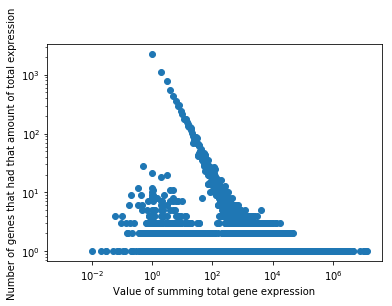

In [9]:
freq_sum_total_expression = Counter(sum_total_expression)
plt.figure(1)
plt.scatter(freq_sum_total_expression.keys(), freq_sum_total_expression.values())
plt.xscale('log')
plt.xlabel("Value of summing total gene expression")
plt.yscale('log')
plt.ylabel("Number of genes that had that amount of total expression")

Text(0,0.5,'Number of genes that had that amount of cells expressing it')

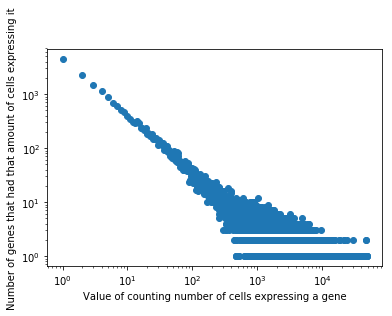

In [10]:
freq_sum_num_cells_expressed = Counter(sum_num_cells_expressed)
plt.figure(2)
plt.scatter(freq_sum_num_cells_expressed.keys(), freq_sum_num_cells_expressed.values())
plt.xscale('log')
plt.xlabel("Value of counting number of cells expressing a gene")
plt.yscale('log')
plt.ylabel("Number of genes that had that amount of cells expressing it")

### Observations
While summing the total expression gives a vague logarithmic correlation, the number of genes expressing a gene expression (Figure 2) is definitely a little more clear. Based on this information and based on trying to get more than 1% of the data to be non-zero, I propose using genes that are expressed in at least 500 cells but no more than 2000. 

In [22]:
row_indices = [index for index, val in enumerate(sum_num_cells_expressed) if val > 0 and val < 1000000]
print(f"New number of genes: {len(row_indices)}")
further_pruned_matrix = np.take(gene_by_cell_minus_expressionless_genes, row_indices, axis=0)
print(f"Number of non-zero entries: {np.count_nonzero(further_pruned_matrix)}. Percentage = {(100 * np.count_nonzero(further_pruned_matrix)) / (further_pruned_matrix.shape[0] * further_pruned_matrix.shape[1])}")

New number of genes: 37263
Number of non-zero entries: 48419474. Percentage = 2.661174264287409


In [25]:
# Woohoo! Let's create a Loom file to use for further noodling.
all_gene_attributes = {}
for key in ds.ra.keys():
    values = []
    for index_in_new, index_in_old in enumerate(row_indices):
        values.append(ds.ra[key][index_in_old])
    all_gene_attributes[key] = np.array(values)

all_cell_attributes = {}
max_cells = 48828
for key in ds.ca.keys():
    values = [ds.ca[key][i] for i in range(0, max_cells)]
    all_cell_attributes[key] = np.array(values)
    
final_matrix=further_pruned_matrix[:, 0:max_cells]
print(final_matrix.shape)
print(len(all_gene_attributes['Gene']))
print(len(all_cell_attributes['CellID']))

filename = "data/modified_hca_sample_3.loom"
loompy.create(filename, final_matrix, all_gene_attributes, all_cell_attributes)

(37263, 48828)
37263
48828


# scVI : https://github.com/YosefLab/scVI
Let's run to see what kinds of useful information we can get out of it!

In [17]:
from scVI.scvi.dataset import LoomDataset
from scVI.scvi.inference import UnsupervisedTrainer
from scVI.scvi.models import *

In [18]:
# Load dataset
hca_subsample_dataset = LoomDataset("modified_hca_sample_3.loom") # Takes a few minutes
print(hca_subsample_dataset.nb_genes)
print(hca_subsample_dataset.n_batches)

File data/modified_hca_sample_3.loom already downloaded
Preprocessing dataset: modified_hca_sample_3.loom
Extracting gene information from dataset
Extracting batch information from dataset
Extracting ethnicity information from dataset
Extracting organ information from dataset
Final matrix shape is: (48828, 37263)
Finished preprocessing dataset
37263
6


In [19]:
# Training parameters
num_epochs = 100
learning_rate = 1e-5
use_batches = False
use_cuda = True
latent_dimensions = 15
hidden_layer_nodes = 512

In [ ]:
vae = VAE(hca_subsample_dataset.nb_genes, 
          n_batch=hca_subsample_dataset.n_batches * use_batches, 
          n_hidden=hidden_layer_nodes, 
          n_latent=latent_dimensions)
trainer = UnsupervisedTrainer(vae,
                              hca_subsample_dataset,
                              train_size=0.75,
                              use_cuda=use_cuda,
                              frequency=5,
                              verbose=True)
trainer.train(n_epochs=num_epochs, lr=learning_rate)


EPOCH [0/100]: 
Train Set : LL : 94585.1995
Test Set : LL : 111921.0298

EPOCH [5/100]: 
Train Set : LL : 21324.1696
Test Set : LL : 21766.1744

EPOCH [10/100]: 
Train Set : LL : 15490.3379
Test Set : LL : 15922.0753

EPOCH [15/100]: 
Train Set : LL : 11834.3554
Test Set : LL : 12176.5046

EPOCH [20/100]: 
Train Set : 
EPOCH [25/100]: 
Train Set : LL : 7280.4748
Test Set : LL : 7244.9186

EPOCH [30/100]: 
Train Set : LL : 5252.1077
Test Set : LL : 5294.3703

EPOCH [35/100]: 
Train Set : LL : 4542.2139
Test Set : LL : 5040.5551

EPOCH [40/100]: 
Train Set : LL : 4090.4584
Test Set : LL : 4189.7893

EPOCH [45/100]: 
Train Set : LL : 3915.8466
Test Set : LL : 4390.1745

EPOCH [50/100]: 
Train Set : LL : 3863.3963
Test Set : LL : 4341.2772

EPOCH [55/100]: 
Train Set : LL : 3932.8460
Test Set : LL : 4499.2380

EPOCH [60/100]: 
Train Set : LL : 3796.4382
Test Set : LL : 3965.9771

EPOCH [65/100]: 
Train Set : LL : 3920.9699
Test Set : LL : 4431.6206

EPOCH [70/100]: 
Train Set : LL : 3801.

[94585.19953544415, 21324.169602994185, 15490.337917025068, 11834.35537328309, 9095.933879297398, 7280.474755348707, 5252.107743209156, 4542.21387756086, 4090.4584248535675, 3915.846592673944, 3863.396314614565, 3932.8459862723917, 3796.438205708473, 3920.9699465897297, 3801.612716768555, 3864.4335437232053, 3861.3072590265833, 3620.190765395026, 4268.185597808464, 3638.90845181897, 3630.0984680920783]


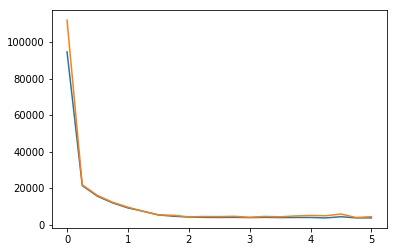

In [21]:
ll_train_set = trainer.history["ll_train_set"]
ll_test_set = trainer.history["ll_test_set"]
print(ll_train_set)
x = np.linspace(0,5,(len(ll_train_set)))
plt.figure(3)
plt.plot(x, ll_train_set)
plt.plot(x, ll_test_set)
plt.show()
#plt.ylim(1150,1600)

In [28]:
import pickle
pickle.dump(trainer.train_set.get_latent(sample=False), open("latent_batch_labels_train", "wb"))
pickle.dump(trainer.test_set.get_latent(sample=False), open("latent_batch_labels_test", "wb"))

In [29]:
latent, _, labels = trainer.train_set.get_latent(sample=False)
print(latent.shape)
print(labels[0])

(36621, 15)
(36621,)


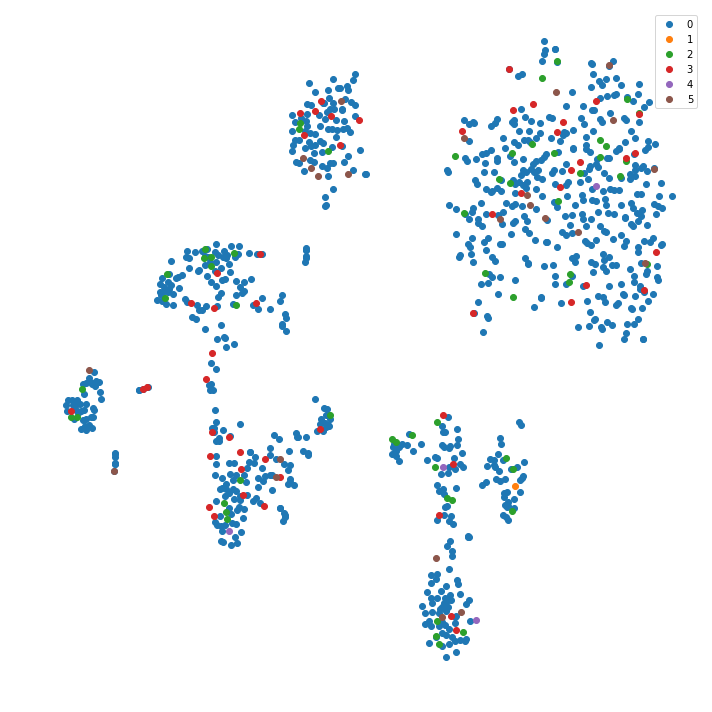

In [22]:
def get_tsne_data(dataset, num_samples):
    latent, batch_indices, labels = dataset.get_latent(sample=True)
    print(latent)
    print(latent.shape)
    print(labels.shape)
    print(labels)
    print(batch_indices)
    
#get_tsne_data(trainer.train_set, 1000)
trainer.train_set.show_t_sne(n_samples=1000, color_by='batches')

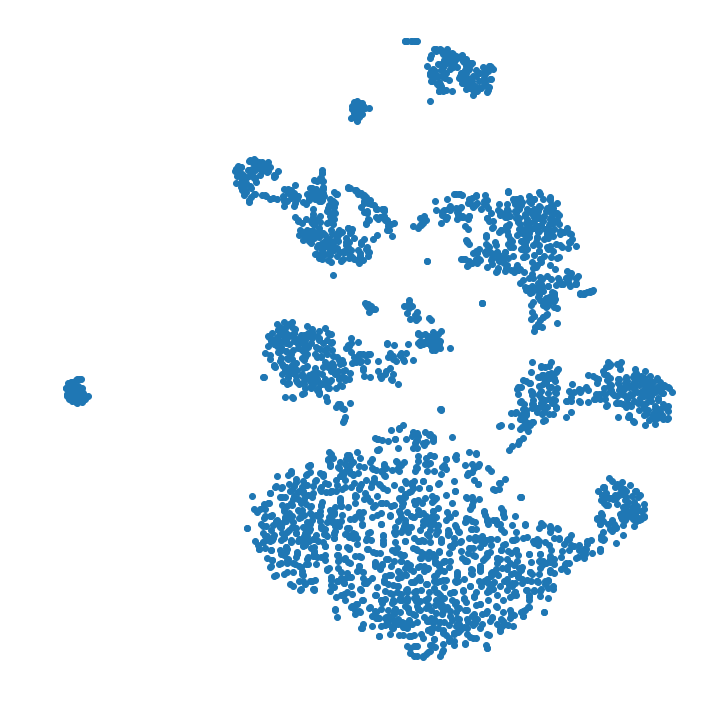

In [23]:
n_samples_tsne = 3000
trainer.train_set.show_t_sne(n_samples=n_samples_tsne)

No handles with labels found to put in legend.


Counter({1: 30886, 3: 11842, 0: 2598, 5: 2221, 2: 619, 7: 427, 6: 154, 4: 81})
[0 1 2 3 4 5 6 7]


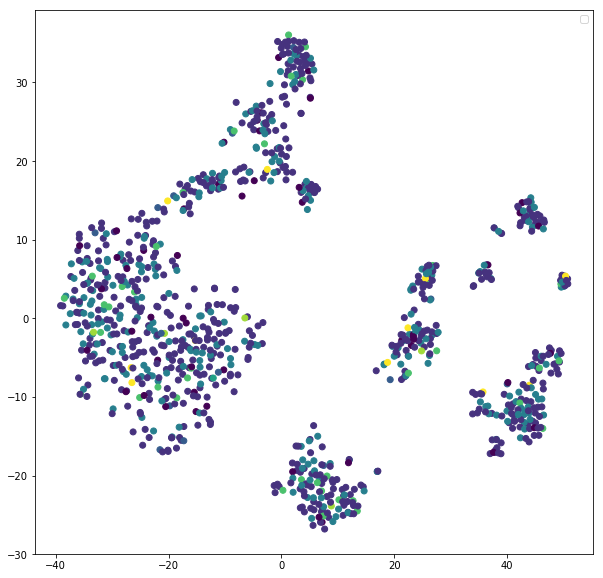

In [24]:
train_set = trainer.train_set
n_samples = 1000

latent, batch_indices, labels = train_set.get_latent(sample=True)
latent, idx_t_sne = train_set.apply_t_sne(latent, n_samples)
batch_indices = batch_indices[idx_t_sne].ravel()
labels = labels[idx_t_sne].ravel()
organ_labels = train_set.gene_dataset.organ_labels[idx_t_sne].ravel()

n_batch = train_set.gene_dataset.n_batches
indices = labels.ravel()
n = train_set.gene_dataset.n_organ_labels
print(Counter(train_set.gene_dataset.organ_labels.ravel()))
plt_labels = train_set.gene_dataset.n_organ_labels
plt.figure(figsize=(10, 10))

organ_by_num = {}
print(np.unique(train_set.gene_dataset.organ_labels.ravel()))
#for i, label in enumerate(np.unique(train_set.gene_dataset.organ_labels.ravel())):
 #   organ_by_num[label] = i
organ_label_nums = []
#for organ_label in organ_labels:
 #   organ_label_nums.append(organ_by_num[organ_label])

#for i, label in zip(range(n, ethnicity_labels)):
 #   plt.scatter(latent[ethnicity_labels == i, 0], latent[indices == i, 1], label=label)
plt.scatter(latent[:, 0], latent[:, 1], c=organ_labels)
#for i, label in zip(range(n), plt_labels):
 #   plt.scatter(latent[ethnicity_labels == i, 0], latent[indices == i, 1], label=label)
plt.legend()


In [21]:
# Close files
ds.close()